In [1]:
import numpy as np
import scipy as sp 
import scipy.ndimage as ndimage
import math
from skimage import exposure,filters
import cv2
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from skimage import morphology
import argparse
import os

In [2]:
image_path = "../Data_Group_Component_Task_1/Test/original_retinal_images/"
HE_mask_path = "../Data_Group_Component_Task_1//Test/masks_Hard_Exudates/"
images = os.listdir(image_path)
HE_masks = os.listdir(HE_mask_path)
images.sort()
HE_masks.sort()

In [3]:
def resize(img):
    ratio  = min([1152/img.shape[0], 1500/img.shape[1]])
    return cv2.resize(img,(int(img.shape[1]*ratio),int(img.shape[0]*ratio)), interpolation = cv2.INTER_CUBIC)


def rgb2Gray(img):
    return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

def clahe_equalized(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl1 = clahe.apply(img)
    return  cl1

def adjust_gamma(img, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    new_imgs = cv2.LUT(img, table)
    return new_imgs

def nearest_neighbor_resize(img, new_w, new_h):
    # height and width of the input img
    h, w = img.shape[0], img.shape[1]
    # new image with rgb channel
    ret_img = np.zeros(shape=(new_h, new_w), dtype='uint8')
    # scale factor
    s_h, s_c = (h * 1.0) / new_h, (w * 1.0) / new_w

    # insert pixel to the new img
    for i in range(new_h):
        for j in range(new_w):
            p_x = int(i * s_c)
            p_y = int(j * s_h)

            ret_img[i, j] = img[p_x, p_y]

    return ret_img

def evaluation(image, mask):
    
    zeros_list_img, one_list_img, zeros_list_mk, one_list_mk = [], [], [], []
    
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            val_mk = mask[i][j]
            val_img  = image[i][j]
            if val_mk == 0:
                zeros_list_mk.append((i,j))
            else:
                one_list_mk.append((i,j))
            if val_img == 0:
                zeros_list_img.append((i,j))
            else:
                one_list_img.append((i,j))
    #print(len(one_list_img))
    TP = len(set(one_list_img).intersection(set(one_list_mk)))
    TN = len(set(zeros_list_img).intersection(set(zeros_list_mk)))
    FP = len(set(one_list_img).intersection(set(zeros_list_mk)))
    FN = len(set(zeros_list_img).intersection(set(one_list_mk)))
    TPR = TP/(FN + TP)
    TNR = TN/(TN + FP)
    P = TP/(TP + FP)
    R = TP/(TP + FN)
    F = 2*(R*P/(R + P))
    JSC = TP/(TP + FP + FN)
    DSC = 2*(TP/(FP + 2*TP + FN))
    return TPR, TNR, F, JSC, DSC

result:


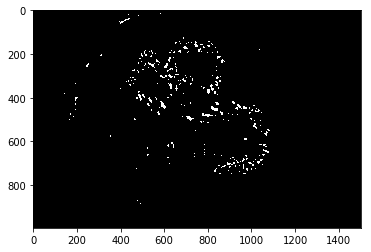

masks_Hard_Exudates:


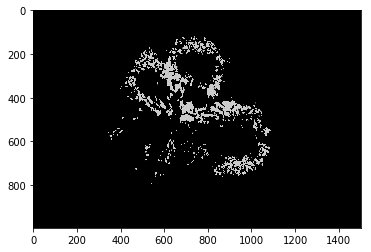

------------------------
JSC = 0.23970603801545418


In [4]:
img_number = 0
image = image_path + images[img_number]
mask = HE_mask_path + HE_masks[img_number]
img = cv2.imread(image)
img = resize(img)
b,g,r = cv2.split(img)

Iw = cv2.addWeighted(r, 0.75, g, 0.25, 0)
Imed = cv2.medianBlur(Iw,3)
Ienhance = clahe_equalized(Imed)
minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(Ienhance)
#print(maxLoc,maxVal)
Pos_row = maxLoc[0]
Pos_col = maxLoc[1]
circle = np.zeros(Ienhance.shape[0:2], dtype="uint8")
disc = cv2.circle(circle, (Pos_row, Pos_col), 135, 1, -1) 

Il = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
L,a,b = cv2.split(Il)
T, B_Fov = cv2.threshold(L, 3, 255, cv2.THRESH_BINARY)
s_FOV = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
B_erode = cv2.erode(B_Fov,s_FOV,iterations = 2)
B_compact = ndimage.binary_fill_holes(B_erode)
B_compact = np.array(B_compact,np.uint8)

Ig = g
med = cv2.medianBlur(Ig,3)
I_G_enhance = clahe_equalized(med)
s_BH = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(30,30))
I_bh = cv2.morphologyEx(I_G_enhance,cv2.MORPH_BLACKHAT, s_BH)
s_TH = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
I_th = cv2.morphologyEx(I_G_enhance,cv2.MORPH_TOPHAT, s_TH)
I_exudate = cv2.subtract(I_th,I_bh)
T, B_exudate = cv2.threshold(I_exudate, 35, 255, cv2.THRESH_BINARY)

Ig_half = cv2.resize(Ig,(int(img.shape[1]/2),int(img.shape[0]/2)),interpolation = cv2.INTER_CUBIC)
med_half = cv2.medianBlur(Ig_half,3)
I_G_enhance_half = clahe_equalized(med_half)
I_bh_half = cv2.morphologyEx(I_G_enhance_half,cv2.MORPH_BLACKHAT, s_BH)
I_th_half = cv2.morphologyEx(I_G_enhance_half,cv2.MORPH_TOPHAT, s_TH)
I_exudate_half = cv2.subtract(I_th_half,I_bh_half)
T, B_exudate_half = cv2.threshold(I_exudate_half, 35, 255, cv2.THRESH_BINARY)
B_exudate_half = nearest_neighbor_resize(B_exudate_half,B_exudate.shape[1],B_exudate.shape[0])
B_dual = cv2.bitwise_or(B_exudate,B_exudate_half)

B_dual = cv2.bitwise_and(B_dual,B_compact)
#B_dual = cv2.subtract(B_dual,disc)
print('result:')
plt.imshow(B_dual,"gray")
plt.show()

mask = cv2.imread(mask)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask = resize(mask)
print('masks_Hard_Exudates:')
plt.imshow(mask,"gray")
plt.show()

print('------------------------')
TPR, TNR, F, JSC, DSC = evaluation(B_dual, mask)
print('JSC = ', end = '')
print(JSC)